<a href="https://colab.research.google.com/github/fongbubble/UoB_MGRCM0034_Group8_Car_Sales/blob/main/XGBoost_%26_ARIMA_Models_for_Quantity_Forecasting_Group_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **XGBoost Model**

## Package

In [22]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

## Data Loading and Preparation

In [23]:
# Load the dataset
car_sales_data = pd.read_csv('Car Sales data.csv')

# Display the first few rows of the dataset
print(car_sales_data.head())
print(car_sales_data.info())

         Car_id      Date Customer Name Gender  Annual Income  \
0  C_CND_000001  1/2/2022     Geraldine   Male          13500   
1  C_CND_000002  1/2/2022           Gia   Male        1480000   
2  C_CND_000003  1/2/2022        Gianna   Male        1035000   
3  C_CND_000004  1/2/2022       Giselle   Male          13500   
4  C_CND_000005  1/2/2022         Grace   Male        1465000   

                           Dealer_Name   Company       Model  \
0  Buddy Storbeck's Diesel Service Inc      Ford  Expedition   
1                     C & M Motors Inc     Dodge     Durango   
2                          Capitol KIA  Cadillac    Eldorado   
3               Chrysler of Tri-Cities    Toyota      Celica   
4                    Chrysler Plymouth     Acura          TL   

                      Engine Transmission       Color  Price ($)  Dealer_No   \
0  DoubleÂ Overhead Camshaft         Auto       Black      26000  06457-3834   
1  DoubleÂ Overhead Camshaft         Auto       Black      19000

## Feature Engineering and Train-Test Split

In [24]:
# Transform data and Train test split
df = car_sales_data.copy()

# Create sales quantity column
df['quantity'] = 1

# Feature Engineering and data cleansing
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['Date'])

# Step 1: Aggregate data to daily totals
daily_data = df.groupby('date').agg({'quantity': 'sum'}).reset_index()

# Step 2: Create time-series features
daily_data['day'] = daily_data['date'].dt.day
daily_data['month'] = daily_data['date'].dt.month
daily_data['year'] = daily_data['date'].dt.year
daily_data['day_of_week'] = daily_data['date'].dt.dayofweek
daily_data['week_of_year'] = daily_data['date'].dt.isocalendar().week
daily_data['lag_1'] = daily_data['quantity'].shift(1)
daily_data['lag_2'] = daily_data['quantity'].shift(2)
daily_data['lag_3'] = daily_data['quantity'].shift(3)
daily_data['lag_4'] = daily_data['quantity'].shift(4)
daily_data['lag_5'] = daily_data['quantity'].shift(5)
daily_data['lag_6'] = daily_data['quantity'].shift(6)
daily_data['lag_7'] = daily_data['quantity'].shift(7)
daily_data['mav_7'] = daily_data['quantity'].rolling(window=7).mean()
daily_data['mstd_7'] = daily_data['quantity'].rolling(window=7).std()

# Drop rows with NaN values from the lagged features
daily_data.dropna(inplace=True)

# Define features and target variable
X = daily_data[['day', 'month', 'year', 'day_of_week', 'week_of_year', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'mav_7', 'mstd_7']]
y = daily_data['quantity']

# Step 3: Split 80-20 time-series style
cutoff_index = X.shape[0]*0.8
X_train = X[:int(cutoff_index)]
X_test = X[int(cutoff_index):]
y_train = y[:int(cutoff_index)]
y_test = y[int(cutoff_index):]

# Print df shape
print('X train:', X_train.shape)
print('X test:', X_test.shape)

X train: (484, 14)
X test: (121, 14)


## Final Model Training and Evaluation

In [25]:
# Parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.3, 0.7, 1],
    'gamma': [0, 1]
}

# Backward Elimination Process
features = X_train.columns.tolist()
best_score = float('inf')
best_features = features.copy()

print("Starting Backward Elimination with Hyperparameter Tuning...\n")

for iteration in range(len(features)):
    print(f"Iteration {iteration + 1}: Current Features -> {features}")
    scores = []

    # Test removing each feature
    for feature in features:
        features_subset = [f for f in features if f != feature]
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

        # Hyperparameter tuning
        randomized_search = RandomizedSearchCV(
            xgb_model, param_distributions=param_grid, scoring='neg_mean_squared_error',
            cv=3, n_iter=10, random_state=42, n_jobs=-1
        )
        randomized_search.fit(X_train[features_subset], y_train)

        # Evaluate on test set
        best_model = randomized_search.best_estimator_
        y_pred = best_model.predict(X_test[features_subset])
        score = mean_squared_error(y_test, y_pred)
        scores.append((score, feature))

        print(f"  Tested removing feature '{feature}', MSE Score: {score:.4f}")

    # Find worst performing feature to remove
    worst_score, worst_feature = max(scores, key=lambda x: x[0])
    print(f"  -> Worst performing feature to remove: {worst_feature} with score {worst_score:.4f}\n")

    # Check if removing the worst feature improved the best score
    if worst_score < best_score:
        best_score = worst_score
        features.remove(worst_feature)
        best_features = features.copy()
        print(f"  Updated Best Score: {best_score:.4f}")
        print(f"  Updated Feature Set: {best_features}\n")
    else:
        print("  No improvement by removing any more features. Stopping elimination.\n")
        break

# Final model training with the selected features
print("Training final model with best features and parameters...")
final_model = xgb.XGBRegressor(objective='reg:squarederror', **randomized_search.best_params_)
final_model.fit(X_train[best_features], y_train)

# Evaluate final model
y_pred = final_model.predict(X_test[best_features])
final_mse = mean_squared_error(y_test, y_pred)
final_rmse = np.sqrt(final_mse)  # RMSE
final_mae = mean_absolute_error(y_test, y_pred)  # MAE
final_r2 = r2_score(y_test, y_pred)  # R^2

# Print the results
print("\nBackward Elimination and Hyperparameter Tuning Completed.")
print("Selected Features:", best_features)
print(f"Final Model Metrics:")
print(f"  Mean Squared Error (MSE): {final_mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {final_rmse:.4f}")
print(f"  Mean Absolute Error (MAE): {final_mae:.4f}")
print(f"  R-squared (R^2): {final_r2:.4f}")

Starting Backward Elimination with Hyperparameter Tuning...

Iteration 1: Current Features -> ['day', 'month', 'year', 'day_of_week', 'week_of_year', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'mav_7', 'mstd_7']
  Tested removing feature 'day', MSE Score: 1190.6141
  Tested removing feature 'month', MSE Score: 1224.6227
  Tested removing feature 'year', MSE Score: 1257.6549
  Tested removing feature 'day_of_week', MSE Score: 1309.1526
  Tested removing feature 'week_of_year', MSE Score: 1176.9536
  Tested removing feature 'lag_1', MSE Score: 1259.5663
  Tested removing feature 'lag_2', MSE Score: 1364.5121
  Tested removing feature 'lag_3', MSE Score: 1304.5956
  Tested removing feature 'lag_4', MSE Score: 1392.3041
  Tested removing feature 'lag_5', MSE Score: 1359.2540
  Tested removing feature 'lag_6', MSE Score: 1247.1460
  Tested removing feature 'lag_7', MSE Score: 1201.7338
  Tested removing feature 'mav_7', MSE Score: 1599.2625
  Tested removing feature 'mst

## Visualize Predicted Test Set

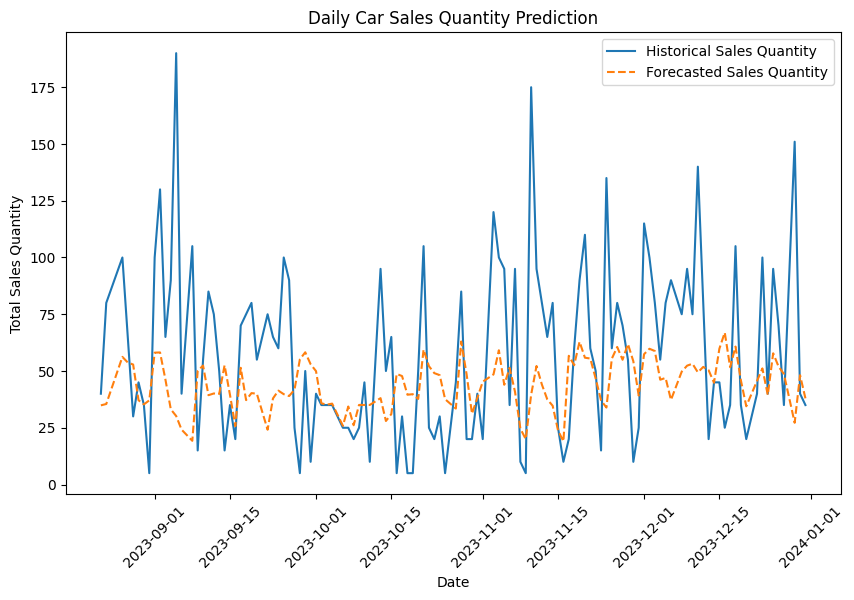

In [26]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(daily_data[int(cutoff_index):]['date'], y_test, label='Historical Sales Quantity')
plt.plot(daily_data[int(cutoff_index):]['date'], y_pred, label='Forecasted Sales Quantity', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Sales Quantity')
plt.title('Daily Car Sales Quantity Prediction')
plt.xticks(rotation=45)
plt.legend()
plt.show()


## Forecasting the Next 3 Months

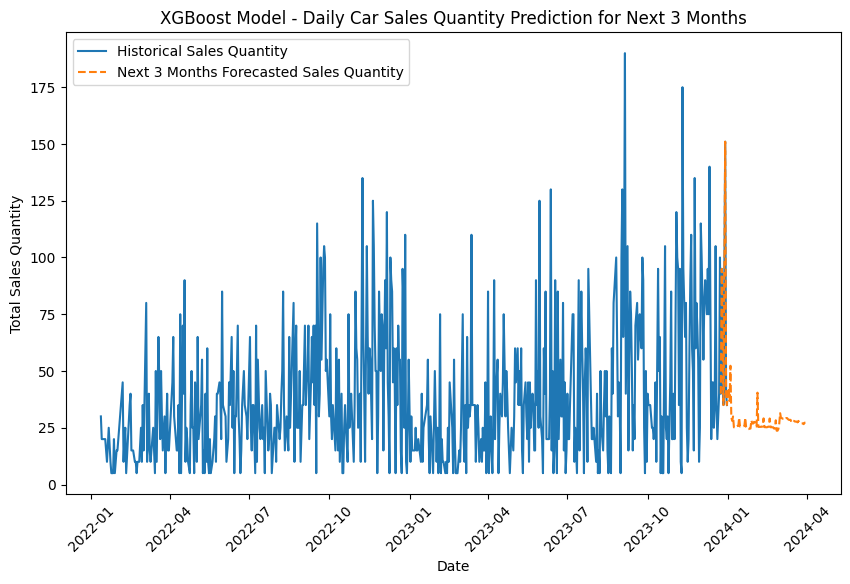

In [5]:
# Predict Next 3 months sales

# Use all data to train the model
best_features = ['day', 'month', 'year', 'day_of_week', 'week_of_year', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'mstd_7']
final_model.fit(X[best_features], y)

# Create a new dataframe with features for the Next 3 months
next_three_months_data = daily_data.tail(7).copy()  # Start with the last available data
rolling_sales_list = daily_data.tail(7)['quantity'].to_list()

# Set the date to next day and then loop to create the Next 3 months
import datetime

for i in range(90):  # Predicting for next 90 days
  next_date = next_three_months_data['date'].max() + datetime.timedelta(days=1)
  new_row = pd.DataFrame({'date': [next_date]})
  new_row['day'] = new_row['date'].dt.day
  new_row['month'] = new_row['date'].dt.month
  new_row['year'] = new_row['date'].dt.year
  new_row['day_of_week'] = new_row['date'].dt.dayofweek
  new_row['week_of_year'] = new_row['date'].dt.isocalendar().week

  # Update lagged features based on previous predictions
  for lag in range(1, 8):
      new_row[f'lag_{lag}'] = rolling_sales_list[-lag]

  # Calculate moving standard deviation
  new_row['mstd_7'] = np.std(rolling_sales_list[-7:])

  # Predict the price using the final model
  new_quantity = final_model.predict(new_row[best_features])

  # Append the predicted quantity to the Next 3 months DataFrame
  new_row['quantity'] = new_quantity
  next_three_months_data = pd.concat([next_three_months_data, new_row])
  rolling_sales_list.append(new_quantity[0])

# Visualize the next year predictions
plt.figure(figsize=(10, 6))
plt.plot(daily_data['date'], daily_data['quantity'], label='Historical Sales Quantity')
plt.plot(next_three_months_data['date'], next_three_months_data['quantity'], label='Next 3 Months Forecasted Sales Quantity', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Sales Quantity')
plt.title('XGBoost Model - Daily Car Sales Quantity Prediction for Next 3 Months')
plt.xticks(rotation=45)
plt.legend()
plt.show()

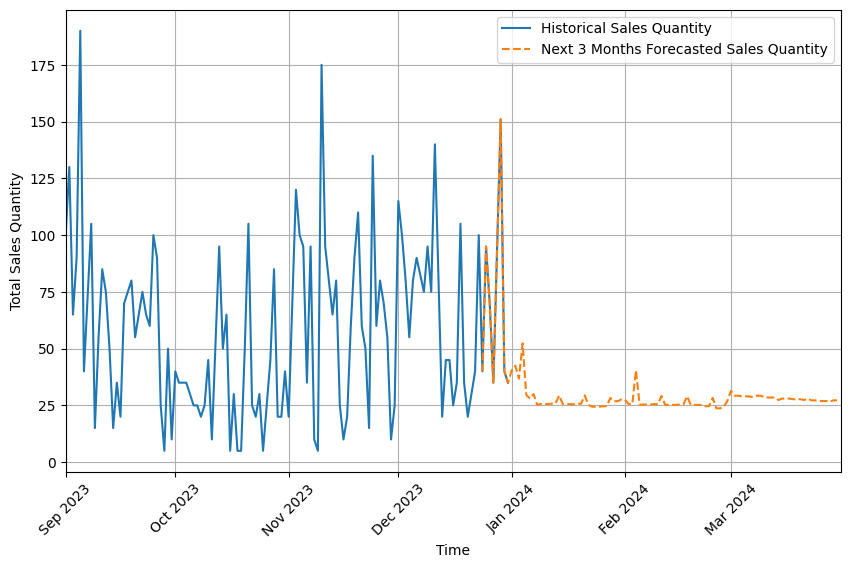

In [6]:
import matplotlib.dates as mdates

# Define the range of dates you want to show
start_date = '2023-09-01'
end_date = '2024-03-31'

# Filter the historical data and predicted data
filtered_historical_data = daily_data[(daily_data['date'] >= start_date) & (daily_data['date'] <= end_date)]
filtered_forecast_data = next_three_months_data[(next_three_months_data['date'] >= start_date) & (next_three_months_data['date'] <= end_date)]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(filtered_historical_data['date'], filtered_historical_data['quantity'], label='Historical Sales Quantity')
plt.plot(filtered_forecast_data['date'], filtered_forecast_data['quantity'], label='Next 3 Months Forecasted Sales Quantity', linestyle='--')

# Set x-axis limits
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Format x-axis for better date readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Total Sales Quantity')
#plt.title('Daily Car Sales Quantity Prediction (Sep 2023 - Apr 2024)')
plt.legend()
plt.grid()
plt.show()


## Exporting Predicted Data

In [7]:
# Filter the predicted daily sales for the year 2024
daily_sales_2024 = next_three_months_data[next_three_months_data['date'].dt.year == 2024][['date', 'quantity']]

# Export the daily sales to a CSV file
output_file_path = 'Predicted_Daily_Sales_Quantity_2024.csv'
daily_sales_2024.to_csv(output_file_path, index=False)

print(f"Predicted daily sales for the year 2024 have been exported to {output_file_path}")


Predicted daily sales for the year 2024 have been exported to Predicted_Daily_Sales_Quantity_2024.csv


# **ARIMA Model**

## Prepare the Data and Data Aggregation

In [8]:
# Aggregate by Quantity
# Group by date and calculate the total quantity of cars sold
car_sales_data['date'] = pd.to_datetime(car_sales_data['Date'])
sales_quantity = car_sales_data.groupby(car_sales_data['date'].dt.to_period('D'))['Car_id'].count().reset_index()
sales_quantity.columns = ['date', 'quantity']
sales_quantity['date'] = sales_quantity['date'].dt.to_timestamp()
sales_quantity.set_index('date', inplace=True)
sales_quantity.sort_index(inplace=True)

# Aggregate the data to daily totals
daily_sales = sales_quantity.groupby('date')['quantity'].sum().reset_index()

# Display the first few rows to confirm structure
print(daily_sales.head())


        date  quantity
0 2022-01-02        35
1 2022-01-03        20
2 2022-01-04        15
3 2022-01-05        30
4 2022-01-06        10


In [9]:
# Fill missing dates with zeros (if there are gaps)
all_dates = pd.date_range(start=sales_quantity.index.min(), end=sales_quantity.index.max(), freq='D')
sales_quantity = sales_quantity.reindex(all_dates, fill_value=0)
sales_quantity.index.name = 'date'

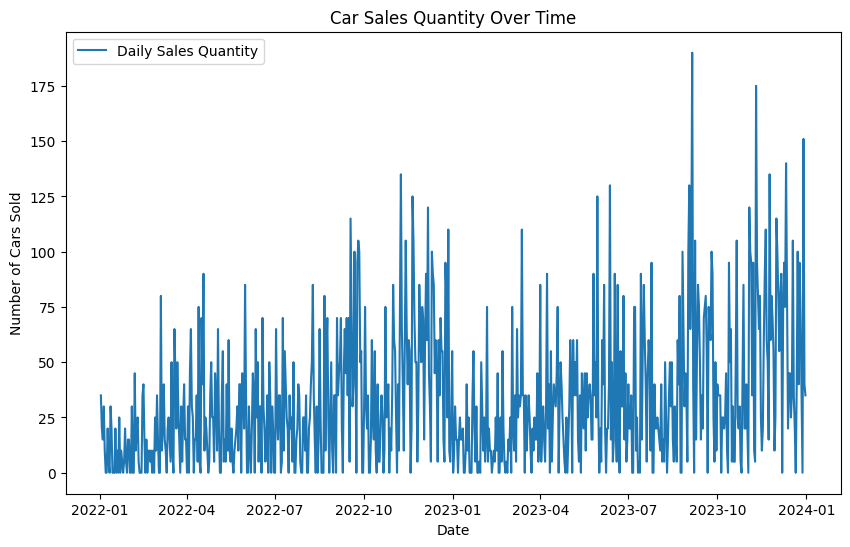

In [10]:
#Visualize Sales Trends
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Access the index using sales_quantity.index
plt.plot(sales_quantity.index, sales_quantity['quantity'], label='Daily Sales Quantity')
plt.xlabel('Date')
plt.ylabel('Number of Cars Sold')
plt.title('Car Sales Quantity Over Time')
plt.legend()
plt.show()


## Time-Series Stationarity and Model Identification

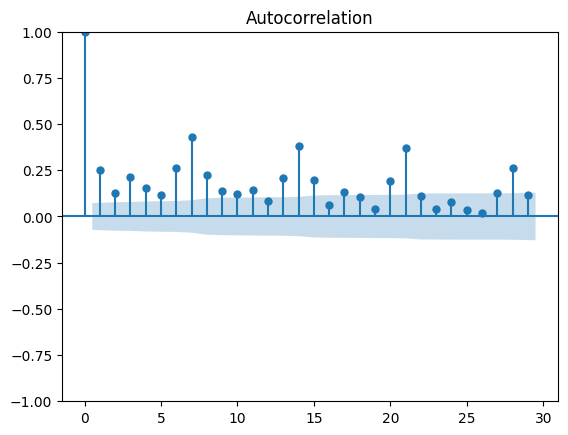

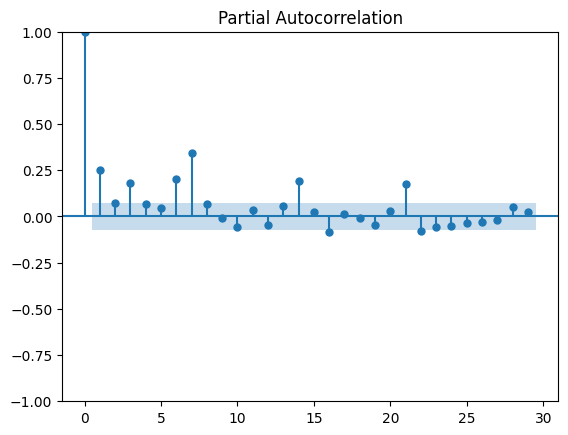

In [11]:
# Identify Parameters (𝑝,𝑑,𝑞)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the stationary series
plot_acf(sales_quantity['quantity'])
plot_pacf(sales_quantity['quantity'])
plt.show()


In [12]:
# Check for Stationarity
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_test = adfuller(sales_quantity['quantity'])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# If p-value > 0.05, the data is non-stationary. Apply differencing.
if adf_test[1] > 0.05:
    sales_quantity['quantity_diff'] = sales_quantity['quantity'].diff().dropna()
else:
    sales_quantity['quantity_diff'] = sales_quantity['quantity']

ADF Statistic: -2.5600523581511623
p-value: 0.10153785894167944


In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Replace p and q with values from ACF/PACF plots
p, d, q = 3, 0, 11

# Train-test split
train_size = int(len(sales_quantity)*0.8)
train, test = sales_quantity[:train_size], sales_quantity[train_size:]

# Fit the ARIMA model
model = ARIMA(train['quantity'], order=(p, d, q))
fitted_model = model.fit()

# Print the summary
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  583
Model:                ARIMA(3, 0, 11)   Log Likelihood               -2686.186
Date:                Mon, 02 Dec 2024   AIC                           5404.372
Time:                        15:47:36   BIC                           5474.263
Sample:                    01-02-2022   HQIC                          5431.614
                         - 08-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.2968      5.088      5.561      0.000      18.324      38.270
ar.L1          0.3726      0.063      5.883      0.000       0.248       0.497
ar.L2         -0.3023      0.071     -4.253      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Residual Diagnostics and Model Evaluation

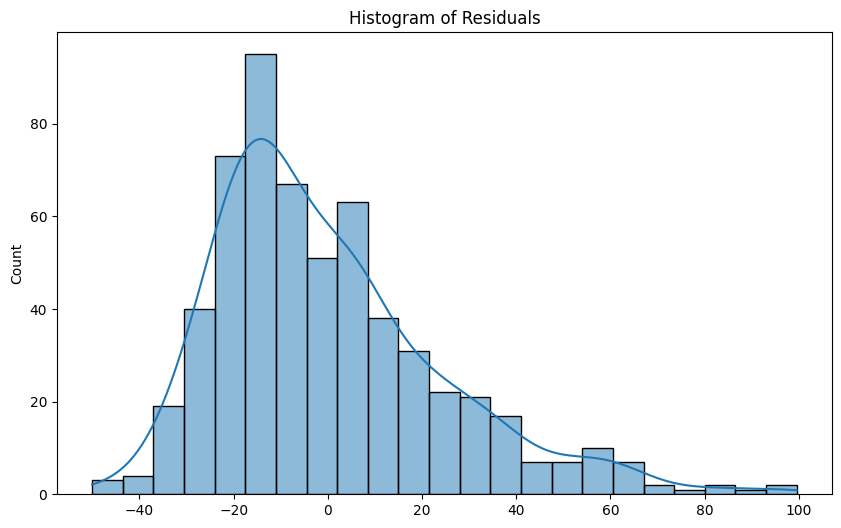

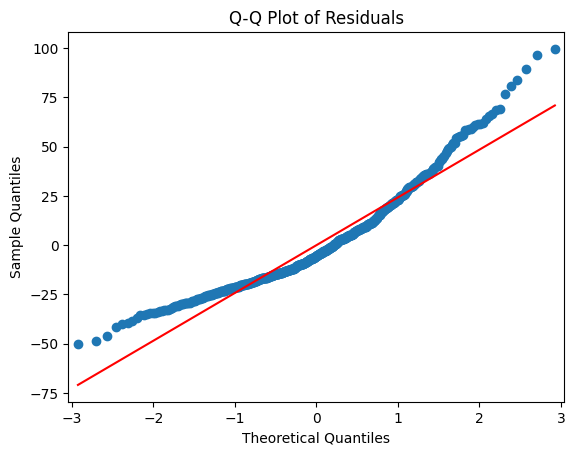

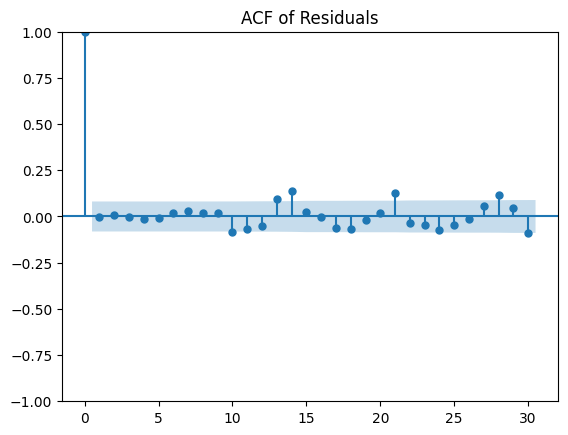

In [15]:
# Residual Analysis
# Plot residuals
residuals = fitted_model.resid

import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# Q-Q plot
import scipy.stats as stats
import statsmodels.api as sm
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Autocorrelation of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=30)
plt.title('ACF of Residuals')
plt.show()


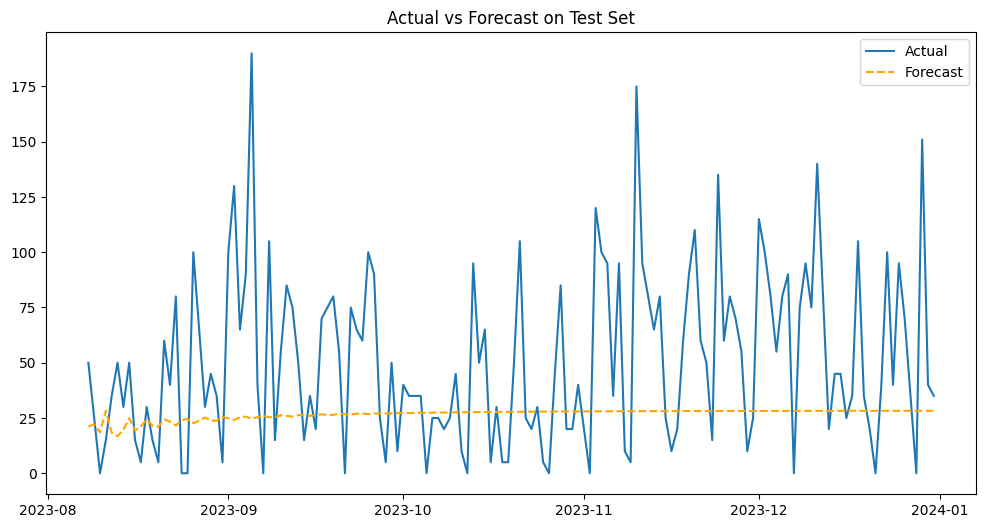

Mean Absolute Error (MAE): 34.02979784983252
Root Mean Squared Error (RMSE): 45.42787067998397


In [16]:
#Train-Test Evaluation
# Forecast on the test set
forecast_test = fitted_model.forecast(steps=len(test))
test['forecast'] = forecast_test

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['quantity'], label='Actual')
plt.plot(test.index, test['forecast'], label='Forecast', linestyle='--', color='orange')
plt.title('Actual vs Forecast on Test Set')
plt.legend()
plt.show()

# Evaluate error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test['quantity'], test['forecast'])
rmse = mean_squared_error(test['quantity'], test['forecast'], squared=False)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


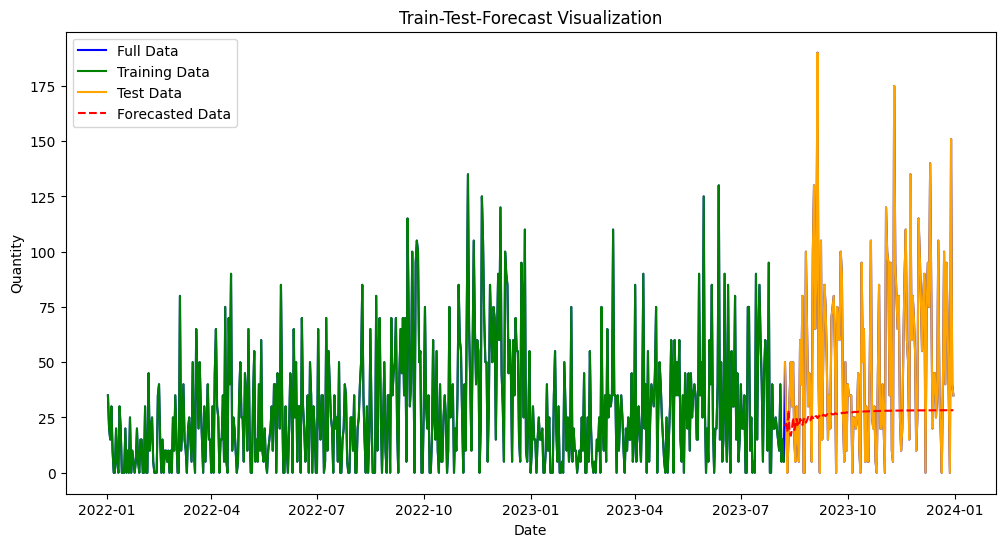

In [17]:
import matplotlib.pyplot as plt

# Forecast on the test set
test_forecast = fitted_model.get_forecast(steps=len(test))
test_forecast_values = test_forecast.predicted_mean

# Plot full data
plt.figure(figsize=(12, 6))
plt.plot(sales_quantity.index, sales_quantity['quantity'], label='Full Data', color='blue')

# Plot training data
plt.plot(train.index, train['quantity'], label='Training Data', color='green')

# Plot test data
plt.plot(test.index, test['quantity'], label='Test Data', color='orange')

# Plot forecasted data
plt.plot(test.index, test_forecast_values, label='Forecasted Data', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Train-Test-Forecast Visualization')
plt.legend()
plt.show()


## Forecasting Future Sales

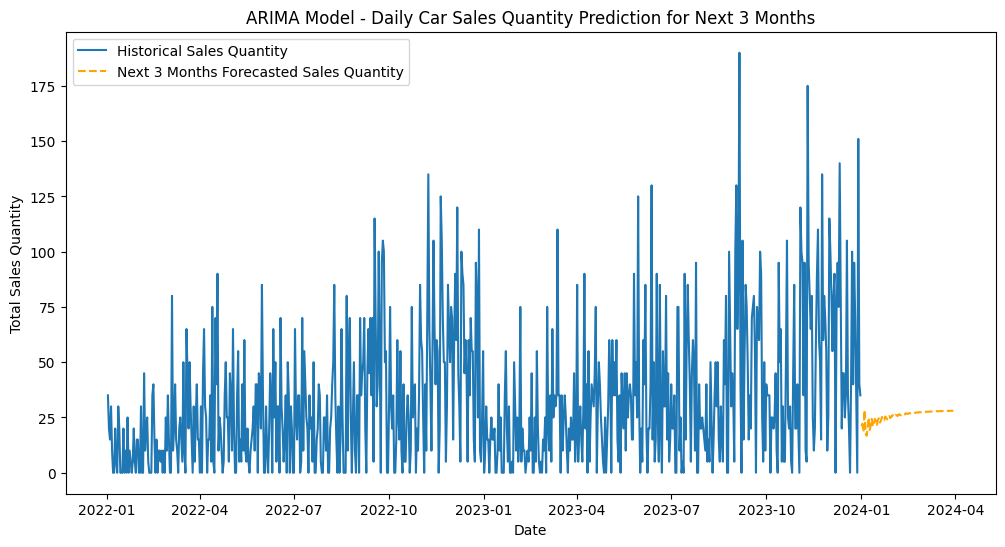

In [18]:
# Forecast the next 90 days
forecast_steps = 90
forecast = fitted_model.forecast(steps=forecast_steps)

# Create future dates
forecast_index = pd.date_range(start=sales_quantity.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df = pd.DataFrame({'date': forecast_index, 'forecast_quantity': forecast})

# Plot historical data and future forecast
plt.figure(figsize=(12, 6))
plt.plot(sales_quantity.index, sales_quantity['quantity'], label='Historical Sales Quantity')
plt.plot(forecast_df['date'], forecast_df['forecast_quantity'], label='Next 3 Months Forecasted Sales Quantity', linestyle='--', color='orange')
plt.xlabel('Date')
plt.ylabel('Total Sales Quantity')
plt.title('ARIMA Model - Daily Car Sales Quantity Prediction for Next 3 Months')
plt.legend()
plt.show()

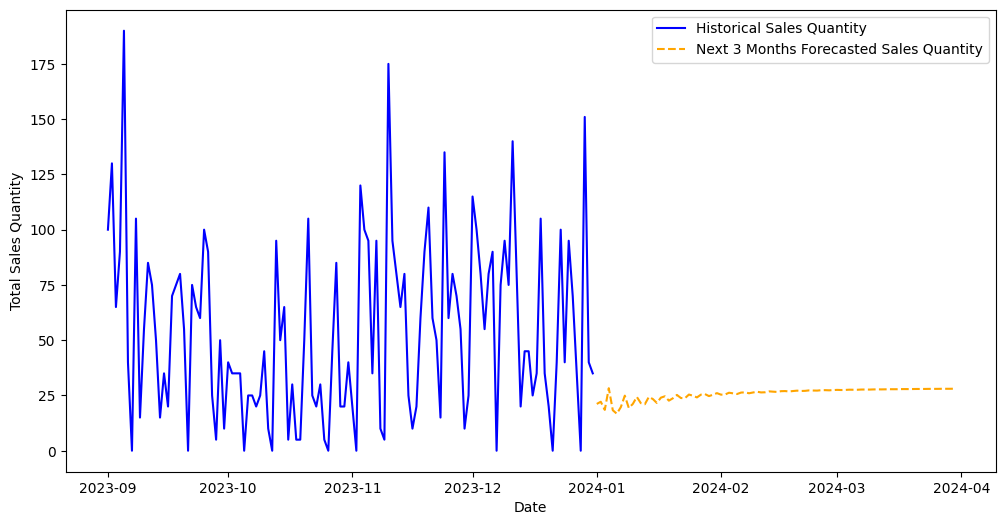

In [19]:
# Filter data for the desired date range (Sep 2023 - Mar 2024)
start_date = '2023-09-01'
end_date = '2024-03-31'

# Filter the historical sales and forecasted data
filtered_historical_data = sales_quantity[(sales_quantity.index >= start_date) & (sales_quantity.index <= end_date)]
filtered_forecast_data = forecast_df[(forecast_df['date'] >= start_date) & (forecast_df['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(12, 6))
plt.plot(filtered_historical_data.index, filtered_historical_data['quantity'], label='Historical Sales Quantity', color='blue')
plt.plot(filtered_forecast_data['date'], filtered_forecast_data['forecast_quantity'], label='Next 3 Months Forecasted Sales Quantity', linestyle='--', color='orange')
plt.xlabel('Date')
plt.ylabel('Total Sales Quantity')
#plt.title('ARIMA Model – Daily Car Sales Quantity Prediction')
plt.legend()
plt.show()


# **Comparison of RMSE and MAE for Models**

In [21]:
import pandas as pd

# Create the DataFrame
summary_df = pd.DataFrame({
    'Model Name': ['ARIMA', 'XGBoost'],
    'RMSE': [45.4279, 40.0468],
    'MAE': [34.0298, 29.6669]
})

# Display the DataFrame
print(summary_df)


  Model Name     RMSE      MAE
0      ARIMA  45.4279  34.0298
1    XGBoost  40.0468  29.6669
